<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
try:
  from gensim.models import Word2Vec
except:
  !pip install gensim
  from gensim.models import Word2Vec

### Datos
Utilizaremos como dataset canciones de bandas de habla inglesa.

In [35]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [36]:
# Posibles bandas
os.listdir("./songs_dataset/")

['dr-seuss.txt',
 'jimi-hendrix.txt',
 'nirvana.txt',
 'lin-manuel-miranda.txt',
 'notorious-big.txt',
 'kanye-west.txt',
 'michael-jackson.txt',
 'dolly-parton.txt',
 'bruno-mars.txt',
 'drake.txt',
 'prince.txt',
 'kanye.txt',
 'ludacris.txt',
 'Lil_Wayne.txt',
 'dj-khaled.txt',
 'r-kelly.txt',
 'eminem.txt',
 'leonard-cohen.txt',
 'nickelback.txt',
 'alicia-keys.txt',
 'blink-182.txt',
 'radiohead.txt',
 'lorde.txt',
 'janisjoplin.txt',
 'rihanna.txt',
 'bob-marley.txt',
 'lady-gaga.txt',
 'patti-smith.txt',
 'cake.txt',
 'dickinson.txt',
 'bruce-springsteen.txt',
 'paul-simon.txt',
 'beatles.txt',
 'notorious_big.txt',
 'al-green.txt',
 'britney-spears.txt',
 'nursery_rhymes.txt',
 'bieber.txt',
 'bjork.txt',
 'Kanye_West.txt',
 'johnny-cash.txt',
 'bob-dylan.txt',
 'adele.txt',
 'lil-wayne.txt',
 'amy-winehouse.txt',
 'missy-elliott.txt',
 'nicki-minaj.txt',
 'disney.txt',
 'joni-mitchell.txt']

In [37]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-3849064916.py:2: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


In [38]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### 1 - Preprocesamiento

In [39]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [40]:
# Demos un vistazo
sentence_tokens[:2]

[['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away'],
 ['now', 'it', 'looks', 'as', 'though', "they're", 'here', 'to', 'stay']]

### 2 - Crear los vectores (word2vec)

In [41]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [42]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [43]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [44]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 1846


In [45]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 445


### 3 - Entrenar embeddings

In [46]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 113045.25
Loss after epoch 1: 65966.59375
Loss after epoch 2: 65934.984375
Loss after epoch 3: 65718.390625
Loss after epoch 4: 63875.09375
Loss after epoch 5: 64160.65625
Loss after epoch 6: 64080.21875
Loss after epoch 7: 64814.875
Loss after epoch 8: 62632.75
Loss after epoch 9: 60452.875
Loss after epoch 10: 59839.875
Loss after epoch 11: 58884.375
Loss after epoch 12: 57715.75
Loss after epoch 13: 56494.3125
Loss after epoch 14: 55817.5
Loss after epoch 15: 55842.9375
Loss after epoch 16: 51722.4375
Loss after epoch 17: 49858.0
Loss after epoch 18: 49592.25
Loss after epoch 19: 48960.125


(156986, 287740)

### 4 - Ensayar

In [47]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["darling"], topn=10)

[('pretty', 0.8954247832298279),
 ('sleep', 0.8665655851364136),
 ('help', 0.8439376354217529),
 ('cry', 0.8351269960403442),
 ('not', 0.8309612274169922),
 ('try', 0.8276943564414978),
 ('peace', 0.8144856691360474),
 ('little', 0.8140572309494019),
 ('twist', 0.8123919367790222),
 ('seems', 0.8079564571380615)]

In [48]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["love"], topn=10)

[('shake', -0.22873197495937347),
 ('four', -0.2330218255519867),
 ('five', -0.23746445775032043),
 ('six', -0.23784494400024414),
 ('bang', -0.24832050502300262),
 ('our', -0.25539135932922363),
 ('day', -0.2689811885356903),
 ('going', -0.2692062556743622),
 ('here', -0.26990723609924316),
 ('three', -0.2838989198207855)]

In [49]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["four"], topn=10)

[('five', 0.9813723564147949),
 ('three', 0.9745770692825317),
 ('six', 0.9710808992385864),
 ('seven', 0.9584357738494873),
 ('two', 0.9517216682434082),
 ('sixty', 0.8990395665168762),
 ('one', 0.7951181530952454),
 ('crying', 0.7946289777755737),
 ('us', 0.7740051746368408),
 ("i'm", 0.7508383393287659)]

In [50]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["money"], topn=5)

[("can't", 0.9434017539024353),
 ('buy', 0.9396998882293701),
 ('much', 0.9033146500587463),
 ('just', 0.8509082198143005),
 ('hide', 0.835538387298584)]

In [51]:
# Ensayar con una palabra que no está en el vocabulario:
# w2v_model.wv.most_similar(negative=["diedaa"])

In [52]:
# el método `get_vector` permite obtener los vectores:
vector_love = w2v_model.wv.get_vector("love")
print(vector_love)

[ 0.06138203  0.05881222 -0.06370417  0.02444947 -0.20152196 -0.18612292
 -0.15284595  0.4548753  -0.04217871  0.03536078  0.13657516 -0.18520005
 -0.1812647   0.22149836 -0.3038084  -0.23970386  0.07094695 -0.05679139
 -0.05166207 -0.23843557 -0.08530281  0.19564727 -0.07678778  0.03797247
  0.07517307 -0.04826551  0.07379535  0.10396848  0.00738022 -0.22764729
 -0.0456724   0.12937619  0.27785638  0.19387618 -0.13509148  0.20857106
  0.40917322 -0.00387122 -0.1063128  -0.09056759  0.02400028 -0.0800491
  0.13400665  0.08833536 -0.01894405  0.08592905 -0.15905626  0.10259357
  0.14459287 -0.12092585 -0.27919102 -0.04061577  0.11382084  0.31365854
 -0.07409792  0.13976744  0.22791271  0.13209458 -0.01811365  0.09772275
  0.09249583 -0.14871688 -0.16348091 -0.13203284 -0.09834065  0.02714608
  0.16531324  0.26051944 -0.0325964  -0.02894551  0.11621328 -0.06974234
  0.09563565 -0.15276384  0.22071053  0.15996666  0.1589048  -0.04711676
 -0.12555045 -0.03993924 -0.10795183  0.01878959  0.

In [53]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_love)

[('love', 0.9999999403953552),
 ('babe', 0.9085132479667664),
 ('someone', 0.8886148929595947),
 ('need', 0.8827974200248718),
 ('nothing', 0.8740269541740417),
 ("didn't", 0.8638361096382141),
 ("there's", 0.8526672720909119),
 ('you', 0.8456704616546631),
 ('feed', 0.8445017337799072),
 ('somebody', 0.8362804651260376)]

In [54]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["love"], topn=10)

[('babe', 0.9085132479667664),
 ('someone', 0.8886148929595947),
 ('need', 0.8827974200248718),
 ('nothing', 0.8740269541740417),
 ("didn't", 0.8638360500335693),
 ("there's", 0.8526672720909119),
 ('you', 0.8456703424453735),
 ('feed', 0.8445016741752625),
 ('somebody', 0.8362804651260376),
 ('buy', 0.8351694941520691)]

### 5 - Visualizar agrupación de vectores

In [55]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [56]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [57]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

In [58]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/


vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

### Consigna del desafío 2

**Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado**

Recuerden que su notebook de entrega debe poder correrse de inicio a fin sin la aparición de errores.

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs.
- Elegir términos de interés y buscar términos más similares y menos similares.
- Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.
- Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)

# Resolución

1 - Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs.

In [59]:
import pandas as pd
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec

# Cargar el archivo de Bob Dylan desde el dataset Songs
df = pd.read_csv('songs_dataset/bob-dylan.txt', sep='/n', header=None, names=['lyrics'])

# Tokenizar las letras
sentence_tokens = []
for _, row in df.iterrows():
    text = str(row['lyrics'])
    tokens = text_to_word_sequence(text)
    if len(tokens) > 0:
        sentence_tokens.append(tokens)

print(f"Cantidad de canciones de Bob Dylan: {len(sentence_tokens)}")

# Entrenar el modelo Word2Vec para Bob Dylan
model_bob_dylan = Word2Vec(
    sentences=sentence_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=30
)

# Chequeo rápido del vocabulario
print(f"Tamaño del vocabulario de Bob Dylan: {len(model_bob_dylan.wv.index_to_key)}")
print("Algunas palabras del vocabulario:", model_bob_dylan.wv.index_to_key[:20])


/tmp/ipython-input-585826121.py:6: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



Cantidad de canciones de Bob Dylan: 5213
Tamaño del vocabulario de Bob Dylan: 2167
Algunas palabras del vocabulario: ['the', 'you', 'i', 'to', 'and', 'a', 'in', 'of', 'my', 'me', 'it', 'your', 'on', 'that', 'is', 'i’m', 'be', 'for', 'but', 'all']


2 - Elegir términos de interés y buscar términos más similares y menos similares.

In [60]:
from numpy.random import default_rng

rng = default_rng(42)

# Elegí algunas palabras que probablemente aparezcan en Bob Dylan
terms = ["love", "night", "time", "road", "rain"]

vocab = list(model_bob_dylan.wv.index_to_key)

for term in terms:
    print("=" * 70)
    print(f"Término de interés: {term}")

    if term not in model_bob_dylan.wv:
        print("  -> Esta palabra no está en el vocabulario del modelo, se salta.\n")
        continue

    # Palabras más similares
    print("\nPalabras más similares:")
    for w, sim in model_bob_dylan.wv.most_similar(term, topn=5):
        print(f"  {w:15s}  similitud = {sim:.3f}")

    # Palabras menos similares (aproximado dentro de un subconjunto del vocabulario)
    # Tomamos un subconjunto aleatorio del vocabulario para no hacerlo demasiado pesado
    subset_size = min(1500, len(vocab))
    subset = rng.choice(vocab, size=subset_size, replace=False)

    sims = []
    for w in subset:
        if w == term:
            continue
        sims.append((w, model_bob_dylan.wv.similarity(term, w)))

    sims_sorted = sorted(sims, key=lambda x: x[1])[:5]

    print("\nPalabras menos similares (dentro de un subconjunto del vocabulario):")
    for w, sim in sims_sorted:
        print(f"  {w:15s}  similitud = {sim:.3f}")

    print()


Término de interés: love

Palabras más similares:
  feelin’          similitud = 0.647
  shot             similitud = 0.614
  pie              similitud = 0.608
  spied            similitud = 0.607
  help             similitud = 0.607

Palabras menos similares (dentro de un subconjunto del vocabulario):
  jolene           similitud = -0.058
  silvio           similitud = -0.047
  gather           similitud = -0.036
  clouds           similitud = -0.017
  storms           similitud = -0.011

Término de interés: night

Palabras más similares:
  world's          similitud = 0.718
  whisperin’       similitud = 0.671
  ahead            similitud = 0.655
  most             similitud = 0.634
  servant          similitud = 0.628

Palabras menos similares (dentro de un subconjunto del vocabulario):
  somebody         similitud = -0.044
  say              similitud = -0.041
  says             similitud = -0.029
  ”                similitud = -0.009
  must             similitud = -0.003

Término

Al revisar las palabras más similares a cada término elegido, se ve que el modelo agrupa palabras que Bob Dylan usa en situaciones parecidas dentro de sus canciones. Por ejemplo, términos como love o night aparecen cerca de otras palabras relacionadas con emociones o imágenes que suelen acompañarlos en sus letras. En cambio, las palabras menos similares provienen de contextos diferentes y no comparten ese uso. Esto muestra que el modelo aprendió a diferenciar bien los distintos tipos de vocabulario del artista.

3 - Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.

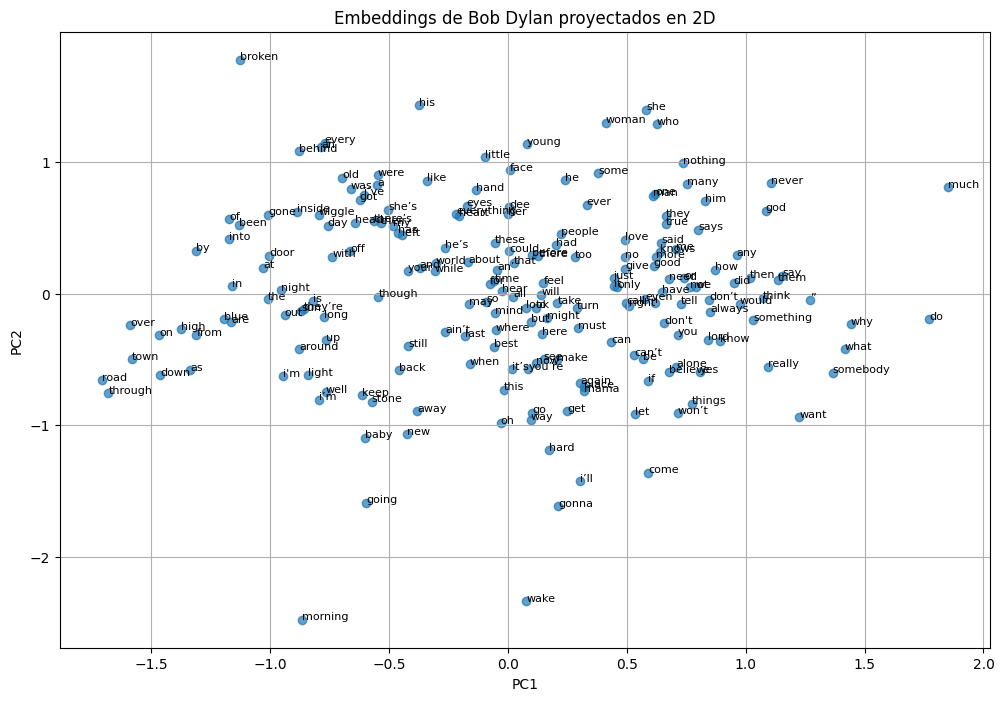

In [61]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Cantidad de palabras a graficar
MAX_WORDS = 200

# Seleccionar las primeras MAX_WORDS del vocabulario
vocab = list(model_bob_dylan.wv.index_to_key)[:MAX_WORDS]
vectors = np.array([model_bob_dylan.wv[word] for word in vocab])

# Reducción de dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Gráfico
plt.figure(figsize=(12, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.7)

# Etiquetas de palabras
for i, word in enumerate(vocab):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=8)

plt.title("Embeddings de Bob Dylan proyectados en 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


Se tomaron hasta MAX_WORDS palabras del vocabulario del modelo Word2Vec entrenado con letras de Bob Dylan y se redujo la dimensionalidad de sus embeddings a 2 dimensiones usando PCA. Luego se graficaron los puntos resultantes junto con el nombre de cada palabra. Esto permite ver cómo se distribuyen y cómo se agrupan las palabras según los contextos en los que aparecen dentro de las canciones del artista.


4 - Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)

En este ejemplo se pueden agrupar palabras relacionadas a canciones sobre viajes, caminos, pueblos. El modelo Word2Vec termina agrupando palabras que comparten el contexto de temáticas sobre trayectos, escenas de ruta o situaciones de desplazamiento

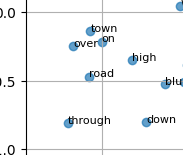



En esta zona aparecen palabras como woman, man, she, who, people, little y one. Son palabras que Bob Dylan usa cuando habla de personas o personajes en sus canciones, por eso el modelo las coloca juntas.

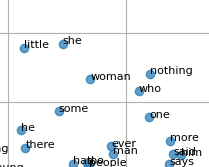

En esta captura, aparecen palabras como going, gonna, wake, morning.
Estas palabras suelen aparecer en contextos de desplazamiento, decisiones, momentos del día, etc.

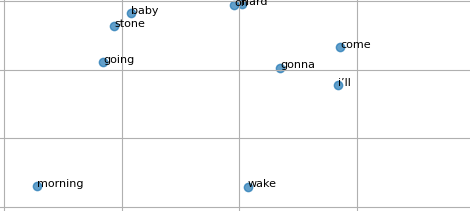

En esta zona aparecen muchas palabras cortas y muy usadas como there, here, so, time, right, world, again, need y these. Son palabras que Bob Dylan usa en muchos tipos de frases y que funcionan como conectores o partes centrales de sus letras

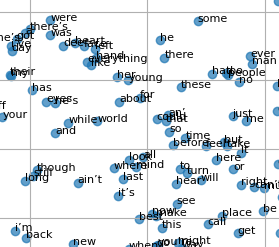